In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
#sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
sys.path.append("/mnt/ssd/MATCH-git/scripts")
import calcOrderParameters as cop
import fnmatch
import re
import gromacs
import pickle
import MDAnalysis as mda
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)
            

In [3]:
class Simulation():
    '''Simulation class stores simulation data relevant for NMRlipids project 6.1 - POPS development'''
    default_ordpars_fname = "OrdPars"  # ending with .dat
    default_bulk_conc_fname = "bulk_conc"  # ending with .dat
    def __init__(self, dirname):
        self.dirname = dirname
        # check presence of required files
        self.top_fname  = "confout.gro"
        self.traj_fname = "traj_comp_pbc.xtc"
        for fname in [self.top_fname, self.traj_fname]:
            try:
                for f in locate(fname, self.dirname):
                    if fname in f:
                        temp_found_file0 = f
                    break
            except:
                print "something went wrong with locating {}".format(fname)
            
        # get topology
        try:
            # locate outputts a generator -- won't work like this
            #self.top_fname = locate("confout.gro", self.dirname).pop()
            #self.traj_fname = locate("traj_comp_pbc.xtc", self.dirname)
            self.topology = mda.Universe(os.path.join(self.dirname, self.top_fname), 
                                         os.path.join(self.dirname, self.traj_fname)) 
        except:
            raise UserWarning, "Error loading topology and trajectory in directory {}".format(self.dirname)
        # select membrane and its components -- very specific for POPC/POPS mixtures!!
        self.membrane_sel = self.topology.select_atoms("resname POPC or resname POPS")
        self.n_lipids = {"all" : len(self.membrane_sel.residues)}
        self.ordpars = dict()
        for lipid in ["POPC", "POPS"]:
            self.n_lipids[lipid] = len(self.topology.select_atoms("resname {}".format(lipid)).residues)
            op_fname_tmp = "{}_{}.dat".format(Simulation.default_ordpars_fname, lipid)
            op_path_tmp  = os.path.join(dirname, op_fname_tmp)
            if self.n_lipids[lipid]:
                try: 
                    self.ordpars[lipid] = cop.parse_op_input(op_path_tmp)
                except:
                    raise UserWarning, "could not get/read order parameters values for {} from {}".format(lipid, 
                                                                                                          op_path_tmp)
        self.n_ions = dict()
        for ion in ["CA", "NA", "K", "CL", "SOL"]:
            self.n_ions[ion] = len(self.topology.select_atoms("resname {}".format(ion)).residues)
        # waters must be present, usually under the resname SOL
        self.n_wat = self.n_ions.pop("SOL")  
        
        if self.n_wat:
            self.conc = dict()
            for ion in self.n_ions.keys():
                self.conc[ion] = 55430.0 * self.n_ions[ion]/self.n_wat  # concentration in mM
        
        for ion in self.conc.keys():
            #print ion, self.n_ions[ion]
            if self.n_ions[ion] >= 1:
                self.conc[ion] = self.get_bulk_conc(ion)
            
            
    def get_bulk_conc(self,ion):
        """get bulk concentration using gromacs density, unless there already is bulk conc. calculated"""
        bulk_conc_file_found = False
        for f in locate("{}_{}.dat".format(Simulation.default_bulk_conc_fname, ion), self.dirname):
            if f:
                with open(f,'r') as of: 
                    # the first line contains the number
                    bulk_conc = float(of.readlines()[0])
                bulk_conc_file_found = True
                print "Reading-in concentration from file for cation {} for simulation with cations {}".format(
                                                                                                ion, self.n_ions)
                break
        if not bulk_conc_file_found:
            self.make_ndx(ion)
            gromacs.density('symm', 'center', 'relative', 
                            s=os.path.join(self.dirname, "topol.tpr"), 
                            f=os.path.join(self.dirname, self.traj_fname), 
                            n=os.path.join(self.dirname, "index_{}.ndx".format(ion)), 
                            o=os.path.join(self.dirname, "dens_{}.xvg".format(ion)), 
                            sl=500,
                            dens='number',
                            xvg='none',
                            input=["membrane", ion])  # "membrane", ion
            dens_profile = np.loadtxt(os.path.join(self.dirname, "dens_{}.xvg".format(ion)))
            if dens_profile.shape[0] > 0:
                means = dens_profile[0:10].mean(axis=0)
                bulk_conc = means[1]/0.602 * 1000.0
                with open(os.path.join(self.dirname, 
                                       "{}_{}.dat".format(Simulation.default_bulk_conc_fname, ion)), 
                          "w") as f:
                    f.write(str(bulk_conc))
            else:
                print "Setting bulk concentration to 0 for simulation with cations: \n {}".format(self.n_ions)
                bulk_conc = 0.0
        return bulk_conc
                
                
    def make_ndx(self,group):
        """ 
        Makes a primitive index file with only two groups: 
        anything that starts wiht POP* and cation of choice.
        """
        group_ids = list()
        pop_ids = list()
        for a in self.topology.atoms:
            if a.resname.startswith("POP"):
                pop_ids.append(a.id)
            elif a.resname == group:
                group_ids.append(a.id)
        
        with open(os.path.join(self.dirname, "index_{}.ndx".format(group)), "w") as f:
            f.write("[ membrane ]\n")
            f.write(" ".join([str(i) for i in pop_ids]))
            f.write("\n")
            f.write("[ {} ]\n".format(group))
            f.write(" ".join([str(i) for i in group_ids]))
            f.write("\n")
            
            

Finding all simulations that finished -- contain confout.gro
==

In [5]:
sim_dirs = []
for f in locate("confout.gro", root=os.curdir):
        sim_dirs.append(os.path.dirname(f))

sim_dirs.sort()
#print sim_dirs

sims = []
for d in sim_dirs:
    sim = Simulation(d)
    # DIRTY fixup for some weird misconfiguration of conf.gro, 
    # where each POPS residue encompasses 8 sub-residues
    if 'POPS' in sim.n_lipids.keys():
        sim.n_lipids['POPS'] /= 8
        sim.n_lipids['all'] = sim.n_lipids['POPS'] + sim.n_lipids['POPC']
    sims.append(sim)
    

Reading-in concentration from file for cation NA for simulation with cations {'NA': 72, 'CA': 0, 'K': 0, 'CL': 0}
Reading-in concentration from file for cation NA for simulation with cations {'NA': 12, 'CA': 13, 'K': 0, 'CL': 26}
Reading-in concentration from file for cation CA for simulation with cations {'NA': 12, 'CA': 13, 'K': 0, 'CL': 26}
Reading-in concentration from file for cation CL for simulation with cations {'NA': 12, 'CA': 13, 'K': 0, 'CL': 26}
Reading-in concentration from file for cation NA for simulation with cations {'NA': 12, 'CA': 26, 'K': 0, 'CL': 52}
Reading-in concentration from file for cation CA for simulation with cations {'NA': 12, 'CA': 26, 'K': 0, 'CL': 52}
Reading-in concentration from file for cation CL for simulation with cations {'NA': 12, 'CA': 26, 'K': 0, 'CL': 52}


getting experimental results for PC:PS mixtures with various salts
===

In [6]:
exp_filenames = []
experiments = {}
freq_to_scd = 0.00748

# DPPC experiments
# find files with the experimental values as read from figure4 in scherer89
for f in locate("*.dat", root="/mnt/ssd/NMRlipids_VI-NewIonModel/Data/POPC-PS_5-1_mix/quadrupolar_splittings_roux1990"):
    exp_filenames.append(f)

for f in exp_filenames:
    bname = os.path.basename(f)
    lipid = None
    if "_pc_" in bname:
        opname = bname[0:bname.find("_pc_")]
        lipid = "POPC"
    elif "_ps_" in bname:
        opname = bname[0:bname.find("_ps_")]
        lipid = "POPS"
    else:
        print "unknown lipid type in file {}".format(f)
    if not experiments.has_key(lipid):
        experiments[lipid] = {}
    for ion in "cacl nacl licl kcl mgcl".split():
        salt = None
        if not experiments[lipid].has_key(ion):
            experiments[lipid][ion] = {}
        if ion in bname:
            salt = ion
            break
    exp_sign = 1.0
    if ("beta" in opname) or ("ps" in bname and "alpha2" in opname):
        exp_sign = -1.0
    data = np.loadtxt(f)
    data[:,1] *= exp_sign*freq_to_scd
    data[:,0] *= 1000.0
    if salt and lipid:
        experiments[lipid][salt].update({opname : data[:,0:2]})
    else:
        print "Problems with detecting salt/lipid in experiment {}".format(bname)
    

#print experiments
        

In [7]:
# working with all ions -- salts

salts = ['cacl', 'nacl', 'kcl']  # also licl, but no simulation 
ion_salt_mapping = dict()
salt_ion_mapping = dict()
for s in salts:
    ion_salt_mapping.update({s.rstrip('cl').swapcase() : s})
    salt_ion_mapping.update({s : s.rstrip('cl').swapcase()})
print 'Mapping of salts-ions:\n{}\n'.format(ion_salt_mapping)

Mapping of salts-ions:
{'NA': 'nacl', 'CA': 'cacl', 'K': 'kcl'}



Sorting simulations into categories (dictionaries)
==

In [8]:
#del(sims_ion_series)
#sims_ion_series = dict.fromkeys(salts, [])  # this one doesn't work and I don't know why
sims_ion_series = dict()
sims_pcpsmix_series = []
for sim in sims:
    salt = []
    if sim.n_lipids['POPC'] > 0 and sim.n_lipids['POPS'] > 0:
        if sim.conc['NA'] < 300.0 and sim.conc['K'] < 0.01:
            salt.append('cacl')
        if sim.conc['NA'] < 300.0 and sim.conc['CA'] < 0.01:
            salt.append('kcl')
        if sim.conc['NA'] > 30.0 and sim.conc['CA'] < 0.01 and sim.conc['K'] < 0.01:
            salt.append('nacl')
        if not len(salt) == 0:
            for s in salt:
                if not s in sims_ion_series.keys():
                    sims_ion_series[s] = []
                sims_ion_series[s].append(sim)
                if s.startswith('nacl') and sim.conc['NA'] < 300.0:
                    sims_pcpsmix_series.append(sim)
        else:
            #print "Simulation with salts {} containing lipids {} not added to any series".format(sim.n_ions, sim.n_lipids)
            pass
    else:
        #print "Simulation with salts {} containing lipids {} not added to any series".format(sim.n_ions, sim.n_lipids)
        sims_pcpsmix_series.append(sim)
        pass
    del(salt)
 

In [9]:
# just a check of how the simulations are sorted
for s in sims_ion_series.keys():
    print "SALT: {}".format(s)
    for sim in sims_ion_series[s]:
        print sim.n_ions

SALT: cacl
{'NA': 12, 'CA': 13, 'K': 0, 'CL': 26}
{'NA': 12, 'CA': 26, 'K': 0, 'CL': 52}
{'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
{'NA': 12, 'CA': 39, 'K': 0, 'CL': 78}
SALT: nacl
{'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
{'NA': 51, 'CA': 0, 'K': 0, 'CL': 39}
SALT: kcl
{'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
{'NA': 12, 'CA': 0, 'K': 39, 'CL': 39}


In [10]:
sims_ordpars = dict()  # nested dictionary: 1. lipid, 2. salts, 3. OP-name, 4. the series
for salt in sims_ion_series.keys():
    print "working with {}".format(salt)
    for sim in sims_ion_series[salt]:
        print "working with simulation with salts {}".format(sim.n_ions)
        for lipid in sim.ordpars:
            if not sims_ordpars.has_key(lipid):
                # using the same "salts" keyword as in experiments -- bit inconsistent, but shall not bring problems
                sims_ordpars[lipid] = {}
            if not sims_ordpars[lipid].has_key(salt):
                sims_ordpars[lipid][salt] = {}
            for op in sim.ordpars[lipid].keys():
                if not sims_ordpars[lipid][salt].has_key(op):
                    sims_ordpars[lipid][salt][op] = list()
                sims_ordpars[lipid][salt][op].append( [sim.conc[salt_ion_mapping[salt]], 
                                                       sim.ordpars[lipid][op].avg,
                                                       sim.ordpars[lipid][op].stem])
                sims_ordpars[lipid][salt][op].sort()
            
#print sims_ordpars_cal

working with cacl
working with simulation with salts {'NA': 12, 'CA': 13, 'K': 0, 'CL': 26}
working with simulation with salts {'NA': 12, 'CA': 26, 'K': 0, 'CL': 52}
working with simulation with salts {'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
working with simulation with salts {'NA': 12, 'CA': 39, 'K': 0, 'CL': 78}
working with nacl
working with simulation with salts {'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
working with simulation with salts {'NA': 51, 'CA': 0, 'K': 0, 'CL': 39}
working with kcl
working with simulation with salts {'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}
working with simulation with salts {'NA': 12, 'CA': 0, 'K': 39, 'CL': 39}


Plotting figure: Changes of order parameters $\alpha$, $\beta$ with various salts
===

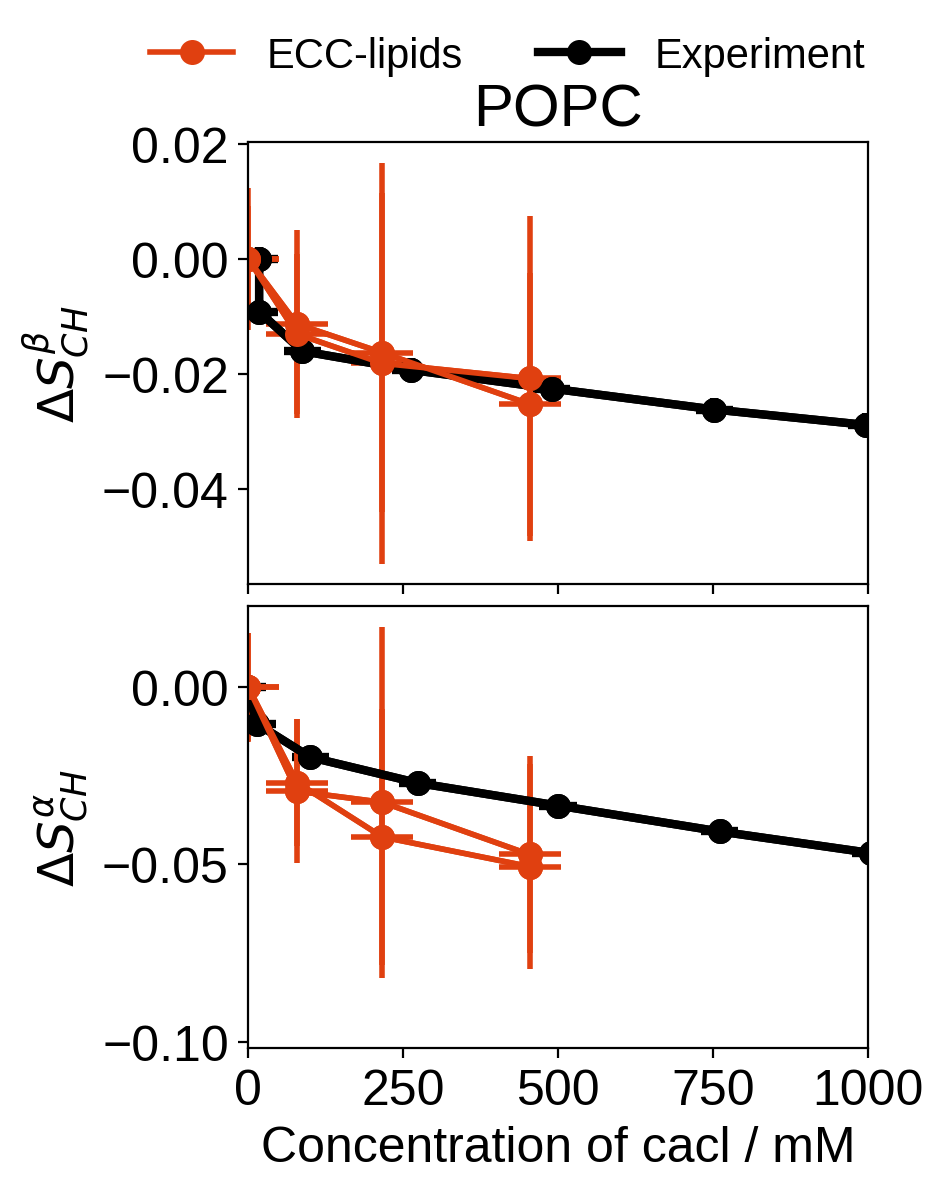

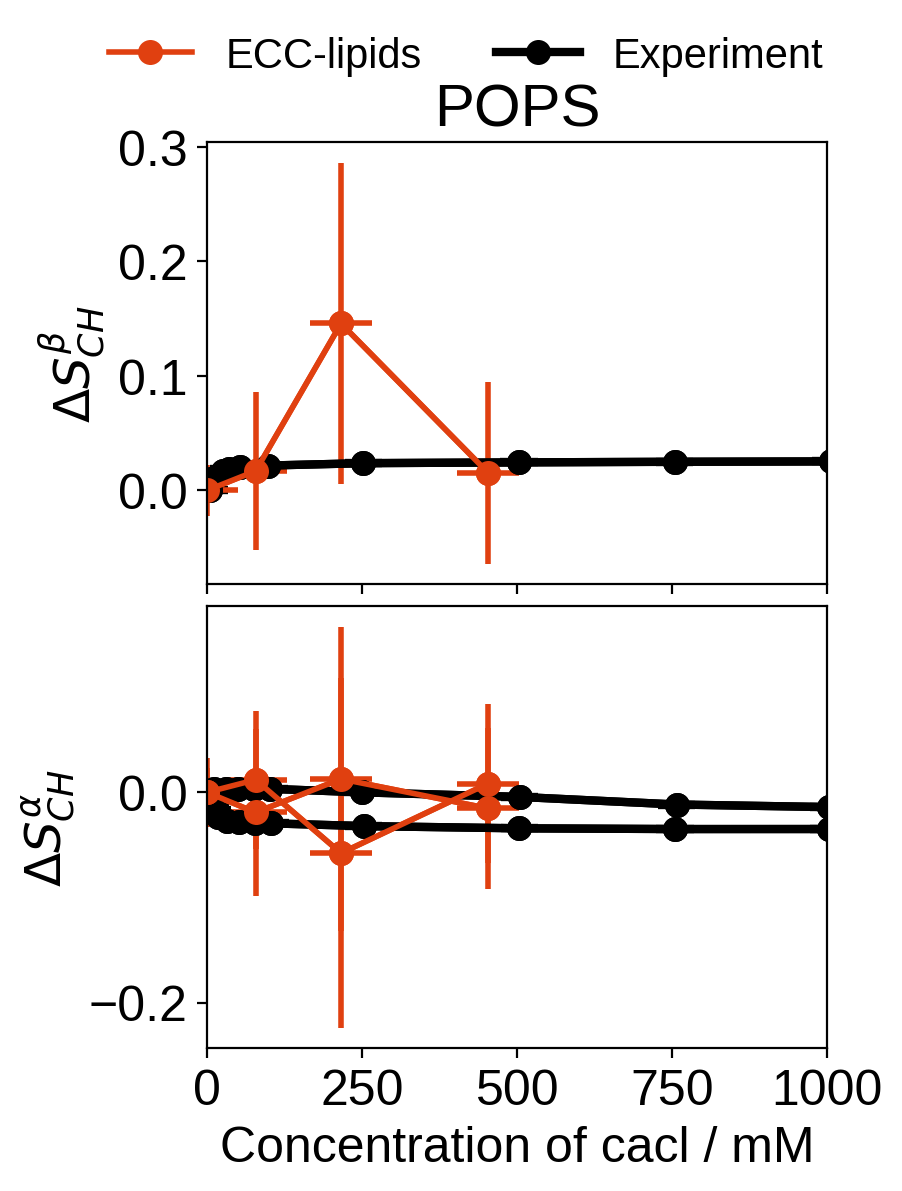

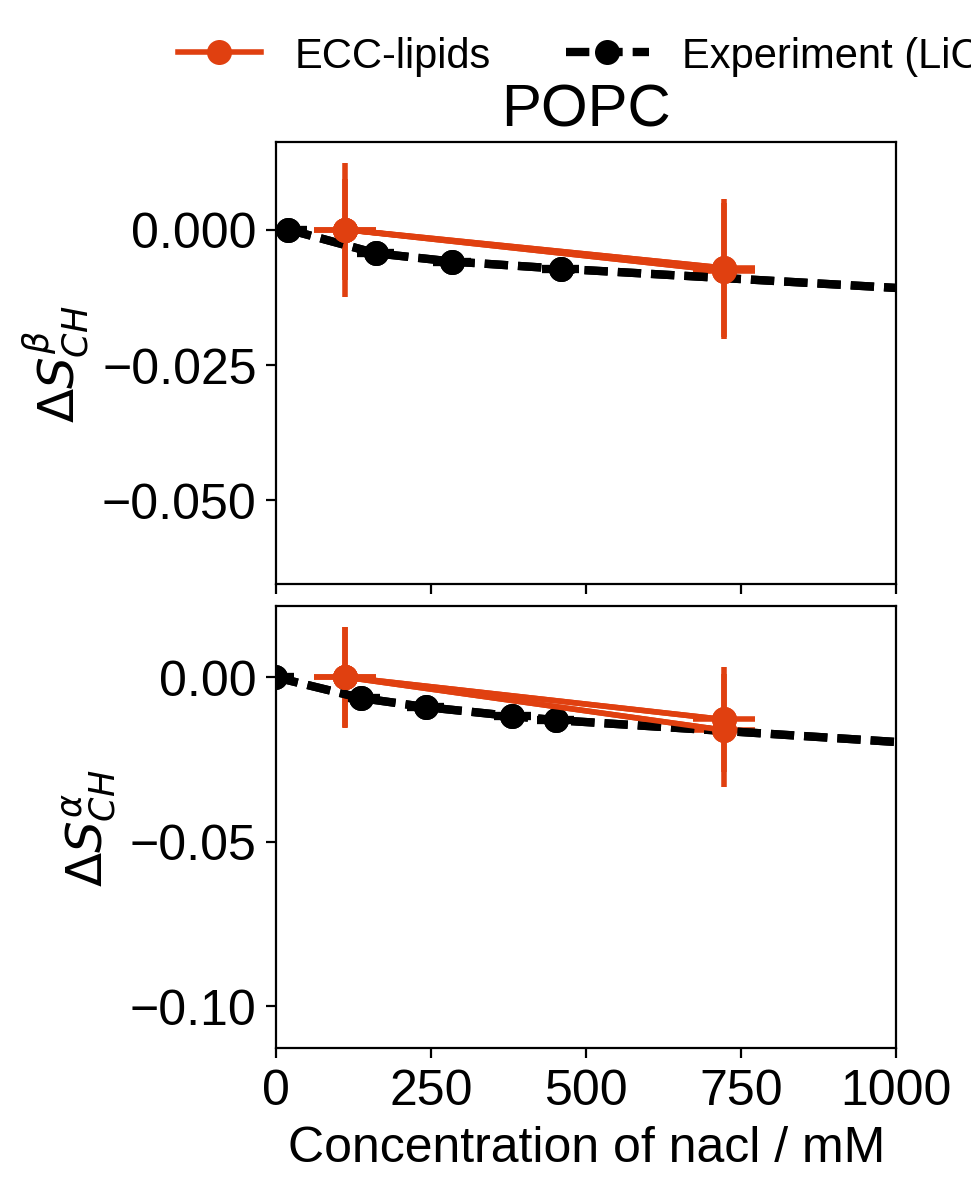

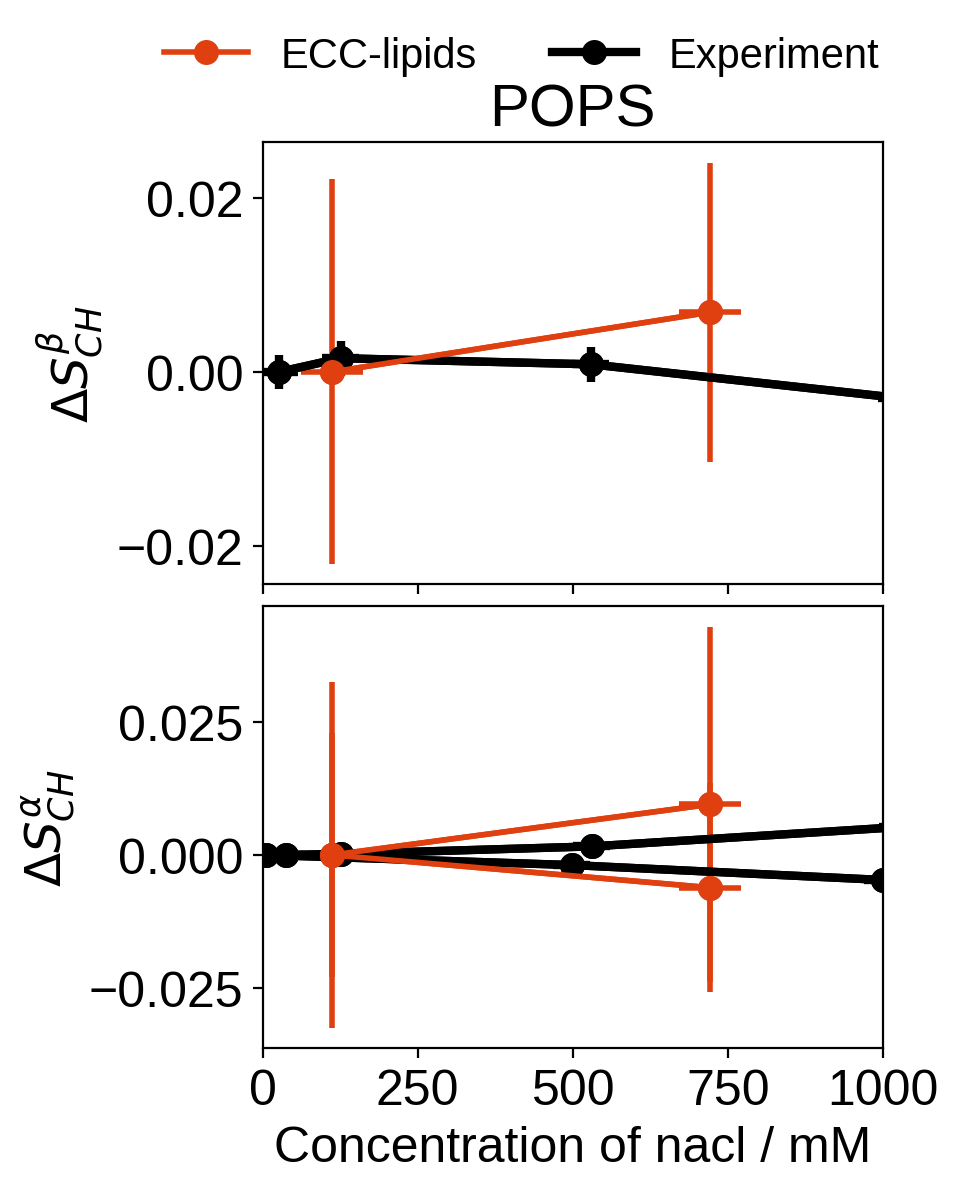

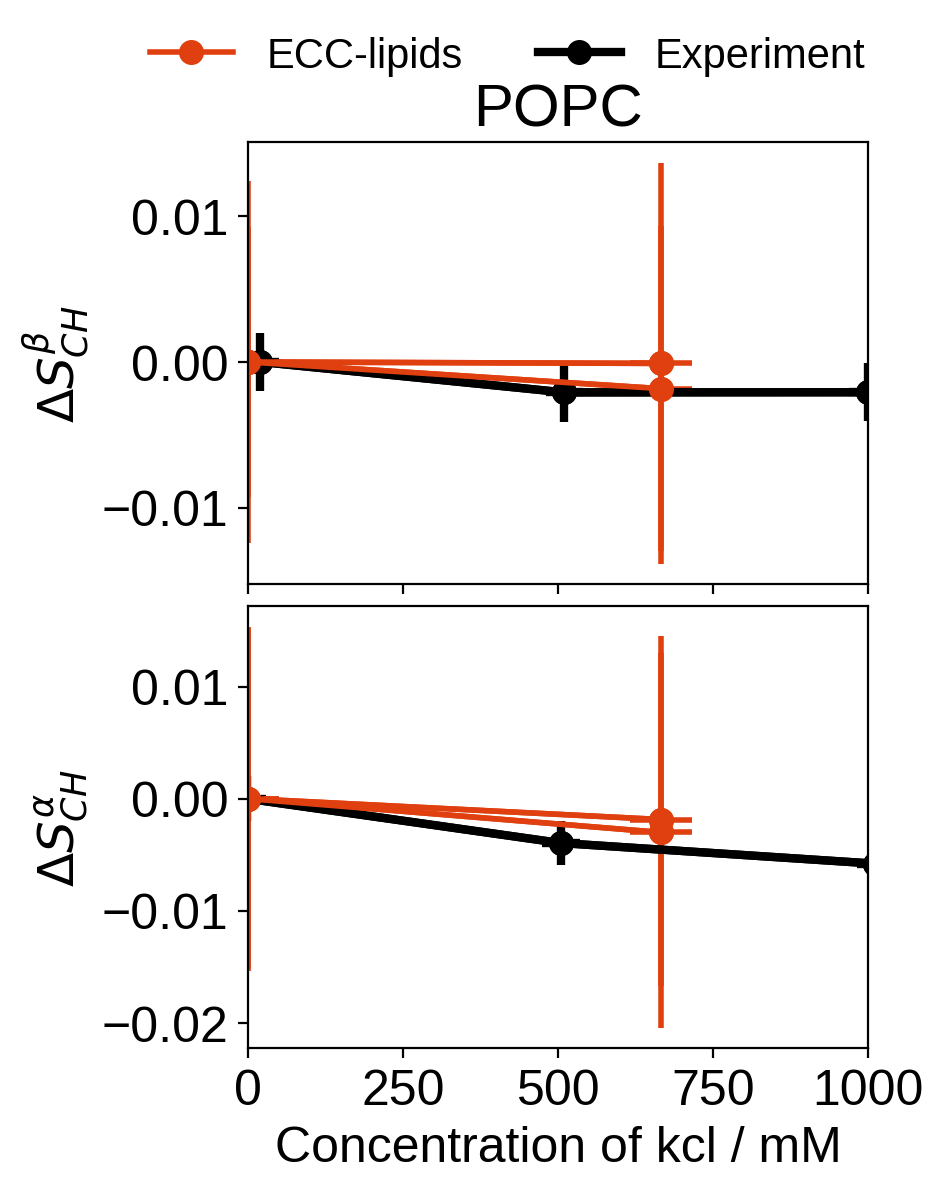

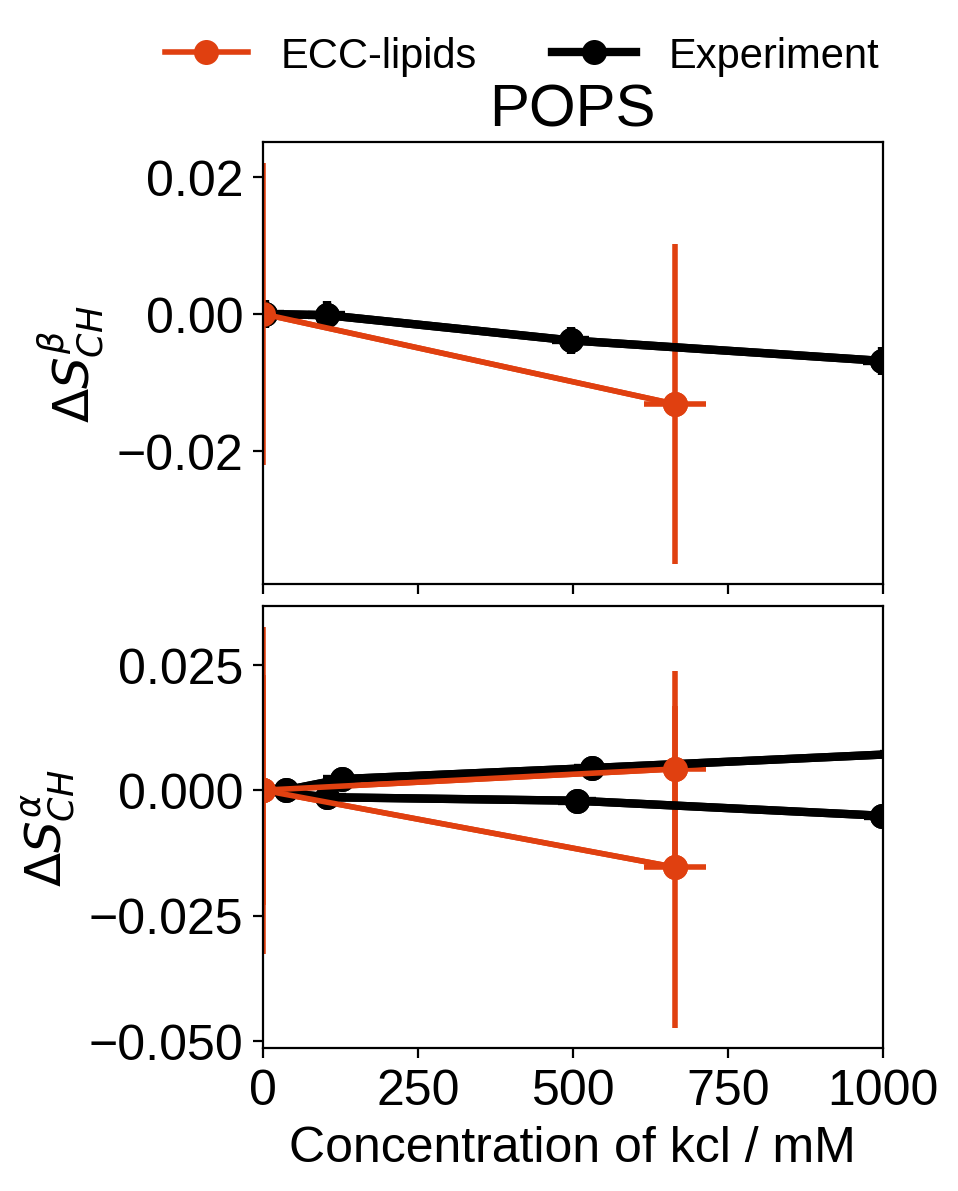

In [11]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


# dirty trick to plot values for licl where there are no values for nacl
experiments['POPC']['nacl'] = experiments['POPC']['licl']


for salt in salts:  #defined above as list
    for lipid in ['POPC', 'POPS']:
        fig, axs = plt.subplots(nrows=2, ncols=1, 
                                sharex="all", figsize=[4,6], 
                                dpi=200)
        fig.subplots_adjust(hspace=0.05)

        #fig.subplotpars.left = 0.3

        # give subplots human-redable names
        dsa = axs[1] # Delta S alpha
        dsb = axs[0] # Delta S beta
        #dsg = axs[2] # Delta S g_3
        #pna = axs[3] # PN_vector

        # add some text for labels, title and axes ticks
        dsa.set_xlabel(r'Concentration of {} / mM'.format(salt))
        #pna.set_ylabel(r'P-N angle')
        dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
        dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')
        #dsg.set_ylabel(r'$\Delta S_{CH} ^{g_3}$')

        #pna.set_xlim([0.0,60.0])
        #ax.set_xticks(r1)
        #xlabelsl = list(xlabels)
        #xlabelsl.extend(range(2, 18))
        #ax.set_xticklabels(xlabelsl, rotation=0)

        dsb.set_title(lipid)

        for (opsplot, c, label) in zip([experiments, sims_ordpars], 
                                       ["black", "#e04010", "#0a77f0", "#608010", '#a00498'], 
                                       ["Experiment", "ECC-lipids", ur"Lipid14 (\u00c5qvist)", "Lipid14 (Dang)", "Lipid14 (ECC-ions)"]):
            for key in opsplot[lipid][salt].keys():
                yerror = 0.001
                do_delta = False
                do_plot = False
                if key.startswith("alpha"):
                    iplt = 1
                    do_delta = True
                    ylim = [-0.06, 0.005]
                    do_plot = True
                elif key.startswith("beta"):
                    iplt = 0
                    do_delta = True
                    ylim = [-0.06, 0.005]
                    do_plot = True
                elif key.startswith("g3"):
                    iplt = 1
                    do_delta = True
                    ylim = [-0.01, 0.139]
                elif key.startswith("PN"):
                    iplt = 1
                    yerror = 0.15
                    ylim = [58.0, 78.0]
                else:
                    #print "this should not happen, setting iplt = 2"
                    iplt = 1
                if "vec" in key:
                    do_plot = False
                if do_plot:
                    ax = axs[iplt]
                    #ax.set_ylim(ylim)
                    if isinstance(opsplot[lipid][salt][key], list):
                        opsplot[lipid][salt][key].sort()
                    else:
                        #print "this is not list, not sorting. It's likely the experimental data."
                        pass
                    data = np.array(opsplot[lipid][salt][key], dtype=float)
                    if do_delta:
                        data[:,1] -= data[0,1]
                    #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
                    linestyle = '-'
                    if 'na' in salt and 'Exp' in label and 'PC' in lipid:
                        # apply a special rule for experimental plot 
                        # -- there are no measurements for NaCl-POPC
                        # -- substitute it with LiCl data
                        linestyle = '--'
                    if key.startswith("alpha1") or key=="alpha":
                        plot_label = label
                        if 'na' in salt and 'Exp' in label and 'PC' in lipid:
                            # apply a special rule for experimental plot 
                            # -- there are no measurements for NaCl-POPC
                            # -- substitute it with LiCl data
                            plot_label = label+" (LiCl data)"
                        if key.endswith("PC"):
                            plot_label += " ("+key[key.rfind("_")+1:]+")"
                    else:
                        plot_label = None
                    marker = "o"
                    markersize = 9
                    if "Exp" in label:
                        linew = 3.0
                        ax.errorbar(data[:,0], data[:,1], xerr=30, yerr=0.002, lw=linew, ls=linestyle, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    else:
                        linew = 2.0
                    if "POPC" in key:
                        marker = "D"
                    if "DPPC" in key:
                        marker = "s"
                    if "ECC" in label:
                        ax.errorbar(data[:,0], data[:,1], xerr=50, yerr=data[:,2], lw=linew, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                        #ax.plot(data[:,0], data[:,1], lw=linew, ls="-", marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    elif "Dang" in label:
                        ax.errorbar(data[-1,0], data[-1:,1], xerr=100, lw=linew, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                        #ax.plot(data[:,0], data[:,1], lw=linew, ls="-", marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    ax.plot(data[:,0], data[:,1], lw=linew, ls=linestyle, marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                else:
                    #print "not plotting data for label {}, lipid {}, OP {}, cation {}".format(label, lipid, key, salt)
                    pass


            for ax in axs:
                #ax.minorticks_on()
                pass

            #xlim = pna.get_xlim()
            #pna.set_xticks(range(0,90,20))
            #pna.set_xticklabels([ str(i)+r"%" for i in range(0,90,20)])
            dsa.set_xlim([0,1000])

            #ylim = pna.get_ylim()
            #pna.set_yticks(range(0,90,5))
            #pna.set_yticklabels([ str(i)+r"$^\circ$" for i in range(0,90,5)])
            #pna.set_ylim(ylim)

            #dsb.legend(loc="lower left", markerscale=1.0, scatterpoints=4, fontsize='x-small')
            dsa.legend(bbox_transform=plt.gcf().transFigure,
                       bbox_to_anchor=(0.44, 1.0), 
                       ncol=2, mode="expand",
                       frameon=False,
                       fontsize='small')

            plt.savefig("order_parameters_changes_A-B_{}_{}.pdf".format(lipid, salt), dpi=200, bbox_inches='tight')
        plt.show()

# delete the licl data from nacl after we're finished plotting them
del(experiments['POPC']['nacl'])

POPC:POPS mixtures - preparing experimental data
===
I have to read proper data instead of reusing the data I have - the experimental conditions may not be correct/same

In [12]:
experiments_pcpsmix = {'POPC' : {'nacl' : {}},
                       'POPS' : {'nacl' : {}}}
salt = 'nacl'
lipid = 'POPS'
for op in experiments[lipid][salt].keys():
    experiments_pcpsmix[lipid][salt][op] = [ [1./6., experiments[lipid][salt][op][0,1]] ]
    
pure_pops_exper_fname = "/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/order_parameter_definitions_ECC-POPS_all.def"
pure_pops_ordpars = cop.parse_op_input(pure_pops_exper_fname)
for op in pure_pops_ordpars.keys():
    if op in experiments_pcpsmix[lipid][salt].keys():
        experiments_pcpsmix[lipid][salt][op].append([ 1., pure_pops_ordpars[op].avg ])

        
lipid = 'POPC'
salt = 'nacl'
for op in experiments[lipid]['kcl'].keys():
    experiments_pcpsmix[lipid][salt][op] = [ [1./6., experiments[lipid]['kcl'][op][0,1]] ]
pure_popc_exper_fname = "/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/order_parameter_definitions_ECC-POPC_all.def"
pure_popc_ordpars = cop.parse_op_input(pure_popc_exper_fname)
for op in pure_popc_ordpars.keys():
    #print op
    # correction for different nomencalture alpha1 x alpha
    opcorr = op.rstrip("1")
    if opcorr in experiments_pcpsmix[lipid][salt].keys():
        experiments_pcpsmix[lipid][salt][opcorr].append([ 0., pure_popc_ordpars[op].avg ])

print experiments_pcpsmix

{'POPC': {'nacl': {'alpha': [[0.16666666666666666, 0.056969573074004798], [0.0, '0.05589248']], 'beta': [[0.16666666666666666, -0.029852991553893198], [0.0, '-0.04478707']]}}, 'POPS': {'nacl': {'alpha2': [[0.16666666666666666, -0.0107071571906332], [1.0, '-0.02']], 'beta': [[0.16666666666666666, -0.093534953271056001], [1.0, '-0.12']], 'alpha1': [[0.16666666666666666, 0.058297040358713199], [1.0, '0.09']]}}}


POPC:POPS mixtures - preparing simulation data
===

In [13]:
sims_ordpars_pcpsmix = dict()  # nested dictionary: 1. lipid, 2. salts, 3. OP-name, 4. the series
salt = 'nacl'
for sim in sims_pcpsmix_series:
    print "working with simulation with salts {}".format(sim.n_ions)
    for lipid in sim.ordpars:
        if not sims_ordpars_pcpsmix.has_key(lipid):
            # using the same "salts" keyword as in experiments -- bit inconsistent, but shall not bring problems
            sims_ordpars_pcpsmix[lipid] = {}
        if not sims_ordpars_pcpsmix[lipid].has_key(salt):
            sims_ordpars_pcpsmix[lipid][salt] = {}
        for op in sim.ordpars[lipid].keys():
            if not sims_ordpars_pcpsmix[lipid][salt].has_key(op):
                sims_ordpars_pcpsmix[lipid][salt][op] = list()
            #mol_fraction = sim.n_lipids[lipid]/float(sim.n_lipids['all'])
            mol_fraction = sim.n_lipids['POPS']/float(sim.n_lipids['all'])
            sims_ordpars_pcpsmix[lipid][salt][op].append([mol_fraction, 
                                                          sim.ordpars[lipid][op].avg,
                                                          sim.ordpars[lipid][op].stem])
            sims_ordpars_pcpsmix[lipid][salt][op].sort()
            
#print sims_ordpars_pcpsmix

working with simulation with salts {'NA': 72, 'CA': 0, 'K': 0, 'CL': 0}
working with simulation with salts {'NA': 12, 'CA': 0, 'K': 0, 'CL': 0}


In [14]:
# working with sims_ordpars_pcpsmix
lipid = 'POPC'
salt = 'nacl'
pure_popc_sim_fname = "/mnt/ssd/NMRlipids_VI-NewIonModel/Data/POPC/no-ions/Lipid14/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref/OrdPars.dat"
# BEWARE: reusing the following variable!
pure_popc_ordpars = cop.parse_op_input(pure_popc_sim_fname)
for op in pure_popc_ordpars.keys():
    #print op
    # correction for different nomencalture alpha1 x alpha
    opcorr = op.rstrip("1")
    if opcorr in sims_ordpars_pcpsmix[lipid][salt].keys():
        sims_ordpars_pcpsmix[lipid][salt][opcorr].append([ 0., pure_popc_ordpars[op].avg, pure_popc_ordpars[op].stem ])

#print sims_ordpars_pcpsmix

Plot of order parameters (resp. changes) upon varying membrane composition - POPC:POPS mixture
==

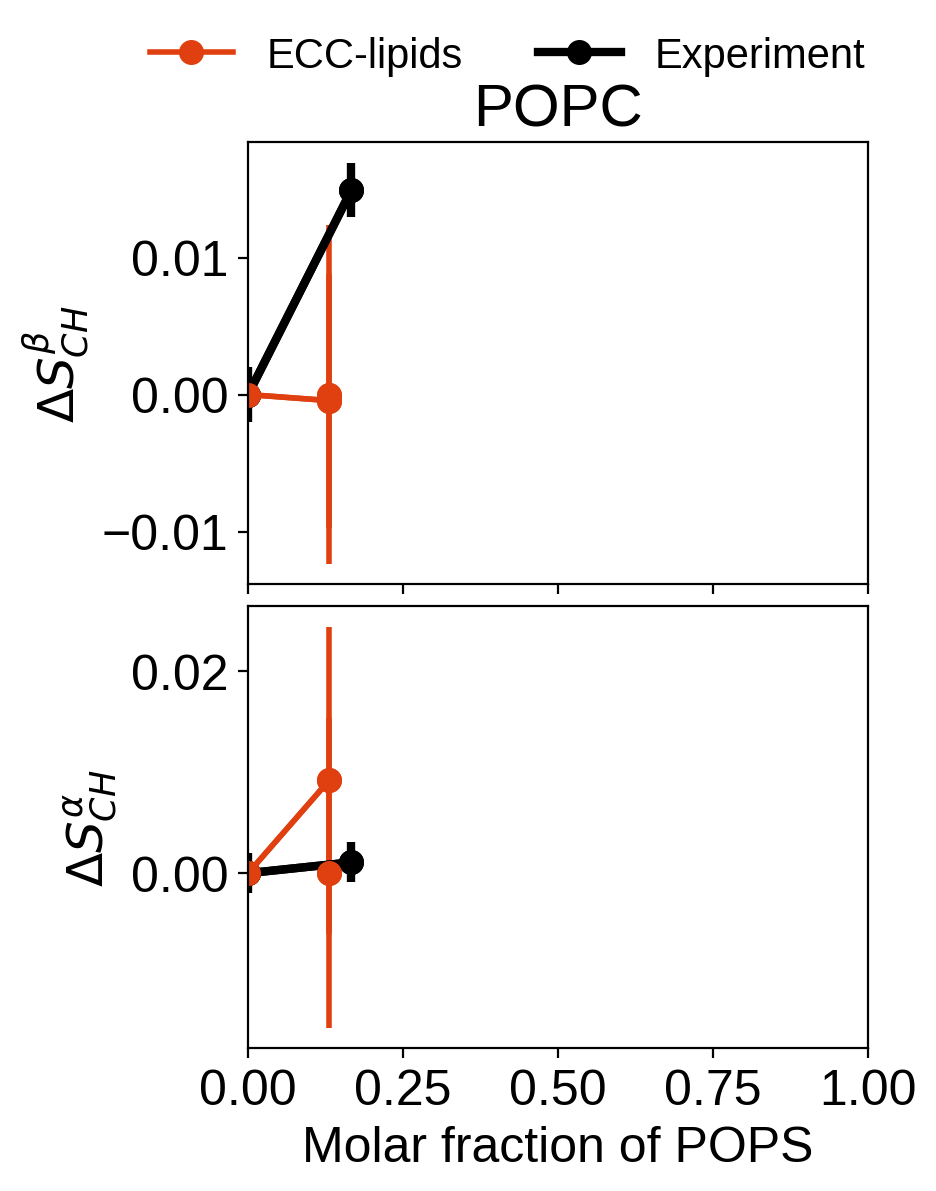

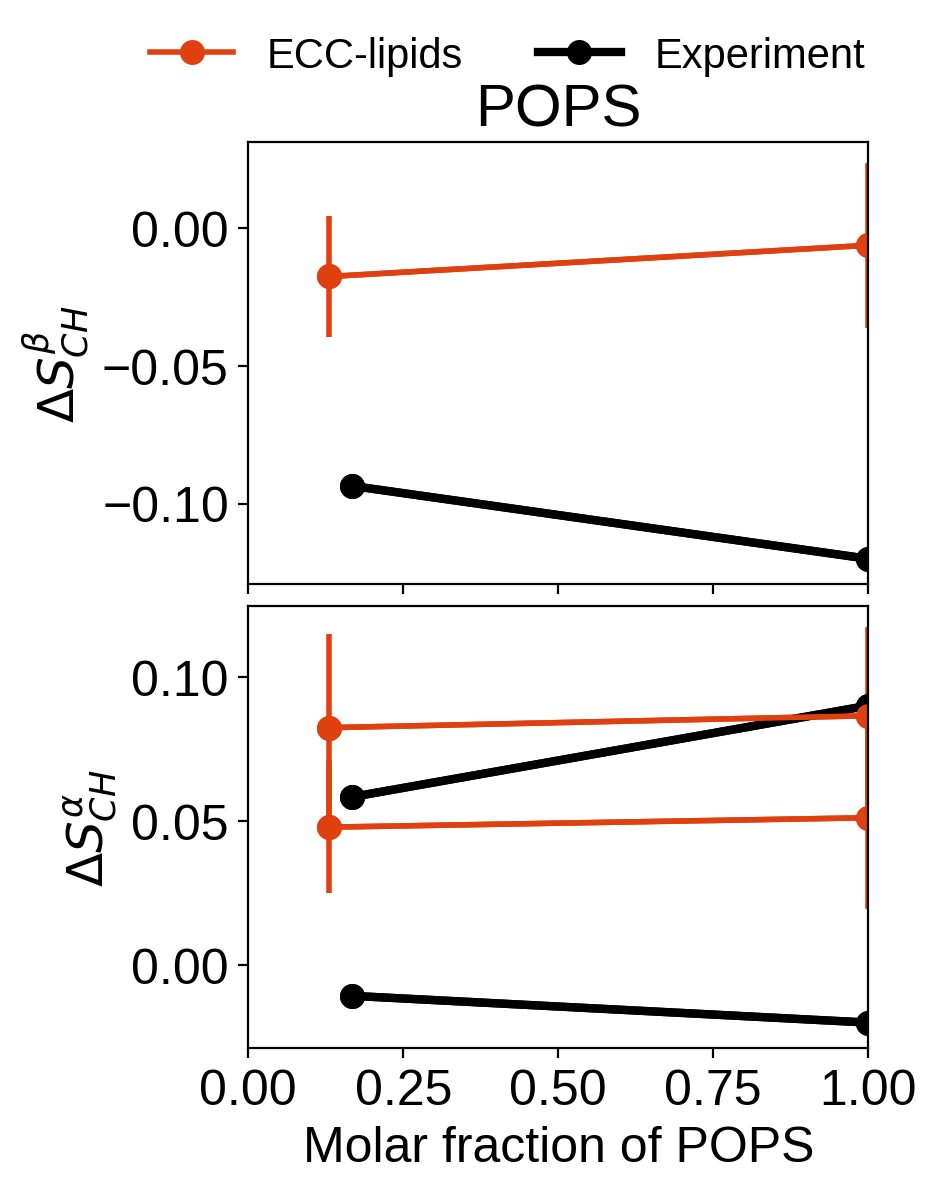

In [15]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


# dirty trick to plot values for licl where there are no values for nacl
#experiments['POPC']['nacl'] = experiments['POPC']['licl']


for salt in ['nacl']:  
    for lipid in ['POPC', 'POPS']:
        fig, axs = plt.subplots(nrows=2, ncols=1, 
                                sharex="all", figsize=[4,6], 
                                dpi=200)
        fig.subplots_adjust(hspace=0.05)

        #fig.subplotpars.left = 0.3

        # give subplots human-redable names
        dsa = axs[1] # Delta S alpha
        dsb = axs[0] # Delta S beta
        #dsg = axs[2] # Delta S g_3
        #pna = axs[3] # PN_vector

        # add some text for labels, title and axes ticks
        dsa.set_xlabel(r'Molar fraction of {}'.format('POPS'))
        #pna.set_ylabel(r'P-N angle')
        dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
        dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')
        #dsg.set_ylabel(r'$\Delta S_{CH} ^{g_3}$')

        #pna.set_xlim([0.0,60.0])
        #ax.set_xticks(r1)
        #xlabelsl = list(xlabels)
        #xlabelsl.extend(range(2, 18))
        #ax.set_xticklabels(xlabelsl, rotation=0)

        dsb.set_title(lipid)

        for (opsplot, c, label) in zip([experiments_pcpsmix, sims_ordpars_pcpsmix], 
                                       ["black", "#e04010", "#0a77f0", "#608010", '#a00498'], 
                                       ["Experiment", "ECC-lipids", ur"Lipid14 (\u00c5qvist)", "Lipid14 (Dang)", "Lipid14 (ECC-ions)"]):
            for key in opsplot[lipid][salt].keys():
                yerror = 0.001
                do_delta = False
                do_plot = False
                if key.startswith("alpha"):
                    iplt = 1
                    do_delta = True
                    ylim = [-0.06, 0.005]
                    do_plot = True
                elif key.startswith("beta"):
                    iplt = 0
                    do_delta = True
                    ylim = [-0.06, 0.005]
                    do_plot = True
                elif key.startswith("g3"):
                    iplt = 1
                    do_delta = True
                    ylim = [-0.01, 0.139]
                elif key.startswith("PN"):
                    iplt = 1
                    yerror = 0.15
                    ylim = [58.0, 78.0]
                else:
                    #print "this should not happen, setting iplt = 2"
                    iplt = 1
                if 'PS' in lipid:
                    do_delta = False
                if "vec" in key:
                    do_plot = False
                if do_plot:
                    ax = axs[iplt]
                    #ax.set_ylim(ylim)
                    if isinstance(opsplot[lipid][salt][key], list):
                        opsplot[lipid][salt][key].sort()
                    else:
                        #print "this is not list, not sorting. It's likely the experimental data."
                        pass
                    #print lipid, salt, key
                    #print opsplot[lipid][salt][key]
                    data = np.array(opsplot[lipid][salt][key], dtype=float)
                    if do_delta:
                        data[:,1] -= data[0,1]
                    #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
                    linestyle = '-'
                    if key.startswith("alpha1") or key=="alpha":
                        plot_label = label
                    else:
                        plot_label = None
                    marker = "o"
                    markersize = 9
                    if "Exp" in label:
                        linew = 3.0
                        ax.errorbar(data[:,0], data[:,1], xerr=0, yerr=0.002, lw=linew, ls=linestyle, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    else:
                        linew = 2.0
                    if "POPC" in key:
                        marker = "D"
                    if "DPPC" in key:
                        marker = "s"
                    if "ECC" in label:
                        ax.errorbar(data[:,0], data[:,1], xerr=0, yerr=data[:,2], lw=linew, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                        #ax.plot(data[:,0], data[:,1], lw=linew, ls="-", marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    elif "Dang" in label:
                        ax.errorbar(data[-1,0], data[-1:,1], xerr=100, lw=linew, marker=marker, markersize=markersize, mew=0, color=c)  #, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                        #ax.plot(data[:,0], data[:,1], lw=linew, ls="-", marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                    ax.plot(data[:,0], data[:,1], lw=linew, ls=linestyle, marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)
                else:
                    #print "not plotting data for label {}, lipid {}, OP {}, cation {}".format(label, lipid, key, salt)
                    pass


            for ax in axs:
                #ax.minorticks_on()
                pass

            #xlim = pna.get_xlim()
            #pna.set_xticks(range(0,90,20))
            #pna.set_xticklabels([ str(i)+r"%" for i in range(0,90,20)])
            dsa.set_xlim([0,1])

            #ylim = pna.get_ylim()
            #pna.set_yticks(range(0,90,5))
            #pna.set_yticklabels([ str(i)+r"$^\circ$" for i in range(0,90,5)])
            #pna.set_ylim(ylim)

            #dsb.legend(loc="lower left", markerscale=1.0, scatterpoints=4, fontsize='x-small')
            dsa.legend(bbox_transform=plt.gcf().transFigure,
                       bbox_to_anchor=(0.44, 1.0), 
                       ncol=2, mode="expand",
                       frameon=False,
                       fontsize='small')

            plt.savefig("order_parameters_changes_A-B_PC-PS_mix_{}_{}.pdf".format(lipid, salt), dpi=200, bbox_inches='tight')
        plt.show()
